# Clustering dataset with mixed dataset

Real-world dataset has both categorical and numerical columns/attributes/features in it. One way of clustering such a dataset without ignoring any of the columns is to use _gower's distance_ followed by a clustering algorithm which supports such a pre-computed distance matrix.

This example notebook is a quick guide to achieve that followed by dimensionality reduction technique to visualize the resulting clusters for an intuitive, visual and quick understanding.

[Refer](https://www.reddit.com/r/learnmachinelearning/comments/hh73d1/gowers_distance/) and [refer](https://stats.stackexchange.com/questions/121916/why-are-mixed-data-a-problem-for-euclidean-based-clustering-algorithms)

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [3]:
!pip install gower

In [5]:
import pandas as pd
import numpy as np
import os
import gower
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

[Adult Data set](https://archive.ics.uci.edu/ml/datasets/adult)

_Abstract_: Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

In [12]:
from google.colab import files

uploaded = files.upload()

Saving adult.data to adult (1).data


In [15]:
# Read in data-
data = pd.read_csv("adult.data")

In [16]:
data.shape

(32561, 15)

In [17]:
data.columns

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-num',
       'Martial-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-Gain', 'Capital-Loss', 'Hours-per-Week', 'Native_Country',
       'Target'],
      dtype='object')

In [18]:
data.select_dtypes(include = 'object').columns

Index(['Workclass', 'Education', 'Martial-Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_Country', 'Target'],
      dtype='object')

In [19]:
data.select_dtypes(include = np.number).columns

Index(['Age', 'fnlwgt', 'Education-num', 'Capital-Gain', 'Capital-Loss',
       'Hours-per-Week'],
      dtype='object')

In [20]:
# Check for missing values-
data.isna().values.any()

False

In [21]:
# Get statistics for numerical columns-
data.describe()

,Age,fnlwgt,Education-num,Capital-Gain,Capital-Loss,Hours-per-Week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [22]:
# Get distribution of target variable-
data['Target'].value_counts()

 <=50K    24720
 >50K      7841
Name: Target, dtype: int64

In [14]:
# Create correlation matrix-
matrix = data.corr()

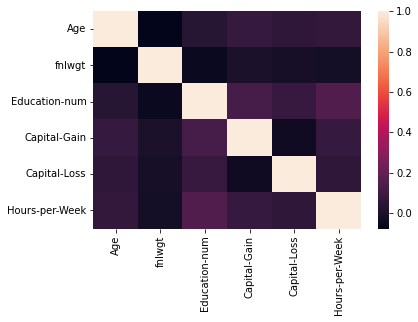

In [15]:
sns.heatmap(matrix)
plt.show()

In [23]:
# Specify columns/attributes to use for clustering-
cols = data.columns.tolist()
cols.remove('Target')

len(cols)

14

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-num   32561 non-null  int64 
 5   Martial-Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital-Gain    32561 non-null  int64 
 11  Capital-Loss    32561 non-null  int64 
 12  Hours-per-Week  32561 non-null  int64 
 13  Native_Country  32561 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Gower's distance
Use _gower distance_ for dataset with mixed columns/attributes followed by _DBSCAN_ clustering algorithm.

#### Projected memory requirements:

32561 x 32561 = 1060218721, 1060218721 x 32 bits = 33926999072 bits

33926999072 / 8 Bytes = 4240874884 Bytes / 1024 = 4141479.37891 KB

4141479.37891 KB / 1024 = 4044.413456 MB / 1024 = 3.94962251559 GB 

In [25]:
# Compute gower distance using specified columns-
gower_dist = gower.gower_matrix(data.loc[:, cols])

In [27]:
type(gower_dist), gower_dist.shape

(numpy.ndarray, (32561, 32561))

In [7]:
# Save as numpy file-
# np.save('gower_matrix_computed.npy', gower_dist)

# Load numpy saved file-
loaded_gower_dist = np.load("gower_matrix_computed.npy")

loaded_gower_dist.shape

(32561, 32561)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!cp gower_matrix_computed.npy /content/drive/MyDrive

In [34]:
# Sanity check-
!ls -lh /content/drive/MyDrive/gower_matrix_computed.npy

-rw------- 1 root root 4.0G Oct 22 16:16 /content/drive/MyDrive/gower_matrix_computed.npy


### Hyper-parameter tune _DBSCAN_ clustering algorithm

In [ ]:
neighbors = NearestNeighbors(n_neighbors = 28)
nbrs = neighbors.fit(loaded_gower_dist)

In [ ]:
distances, indices = nbrs.kneighbors(gower_dist)
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]

In [ ]:
# Visualize optimal value of 'eps'-
plt.plot(distances)
plt.xlabel("distances")
plt.ylabel("distance threshold - epsilon")
plt.title("DBSCAN optimal eps parameter")
plt.show()

In [ ]:
# Train DBSCAN using 'optimal' values-
db_model = DBSCAN(eps = , min_samples = 28, metric = 'precomputed')
db_model.fit(loaded_gower_dist)

print(f"number of clusters found = {len(db_models.labels_) - 1}")